In [2]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn import metrics

def lg_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    for idx in range(14): # ignore 'ID'
        rmse = metrics.mean_squared_error(gt[:,idx], preds[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:15])
    return score, all_nrmse

def train_and_predict_single(df, col, LR):
    train_df, valid_df = train_test_split(df, train_size=0.9)

    train_x = train_df.filter(regex='X') # Input : X Featrue
    train_y = train_df.filter(regex='Y')[col] # Output : Y Feature

    valid_x = valid_df.filter(regex='X') # Input : X Featrue
    valid_y = valid_df.filter(regex='Y')[col] # Output : Y Feature

    LR.fit(train_x, train_y)
    valid_preds = LR.predict(valid_x)
    
    rmse = metrics.mean_squared_error(valid_y, valid_preds, squared=False)
    nrmse = rmse/np.mean(np.abs(valid_y))

    return nrmse, LR
    
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('train.csv')

train_df, valid_df = train_test_split(df, train_size=0.9)

train_x = train_df.filter(regex='X') # Input : X Featrue
train_y = train_df.filter(regex='Y') # Output : Y Feature

valid_x = valid_df.filter(regex='X') # Input : X Featrue
valid_y = valid_df.filter(regex='Y') # Output : Y Feature

LR = MultiOutputRegressor(LinearRegression()).fit(train_x, train_y)

valid_preds = LR.predict(valid_x)
lg_nrmse(valid_y.values, valid_preds)

(1.9655100232179565,
 [0.2582435474168564,
  0.35623405201627245,
  0.35137871384900543,
  0.1929786475739695,
  0.0788833308781518,
  0.10431327278131991,
  0.12979274229765683,
  0.024381327714683772,
  0.024064556818369425,
  0.0393655161086211,
  0.03398042315490278,
  0.024229125011438087,
  0.02421798664989987,
  0.024205654041226068])

In [25]:
col_mean = dict(train_y.describe().loc['mean'])
col_mean

{'Y_01': 1.5391693617021283,
 'Y_02': 1.265785815602839,
 'Y_03': 1.2455534751773039,
 'Y_04': 12.650259574468128,
 'Y_05': 30.78323773049641,
 'Y_06': 15.492205390070957,
 'Y_07': 3.2256451063829763,
 'Y_08': -26.525757730496487,
 'Y_09': -26.54174014184393,
 'Y_10': -22.835638865248253,
 'Y_11': 24.01992794326238,
 'Y_12': -26.469803404255302,
 'Y_13': -26.46407290780134,
 'Y_14': -26.476436595744698}

In [26]:
cur_level = 30
size = len(train_df)
rest = size % cur_level
final_score = {}
for col in valid_y.columns:
    LR = LinearRegression()

    index = abs(train_df[col] - col_mean[col]).sort_values().index
    train_df = train_df.loc[index]
    
    for level in range(1, cur_level+1):
        nxt = size//cur_level*level
        train_x = train_df[:nxt].filter(regex='X')
        train_y = train_df[:nxt].filter(regex='Y')[col]

        LR.fit(train_x, train_y)

        valid_preds = LR.predict(valid_x)
        rmse = metrics.mean_squared_error(valid_y[col], valid_preds, squared=False)
        nrmse = rmse/np.mean(np.abs(valid_y[col]))
        # print(col, level, nrmse)
    final_score[col] = nrmse
sum([v if k in valid_y.columns[7:] else v * 1.2 for k, v in final_score.items()]), final_score

(3.2213564293338015,
 {'Y_01': 0.39818953603054263,
  'Y_02': 0.47940708690219797,
  'Y_03': 0.473848539821713,
  'Y_04': 0.42803136239202016,
  'Y_05': 0.10978487761312264,
  'Y_06': 0.33672932471572875,
  'Y_07': 0.2253430190764516,
  'Y_08': 0.03190083299212381,
  'Y_09': 0.032173779239981264,
  'Y_10': 0.07067517441782786,
  'Y_11': 0.04910638128229328,
  'Y_12': 0.03188952537510668,
  'Y_13': 0.032067097540049494,
  'Y_14': 0.03194314262428699})

In [16]:
valid_y.columns[7:]

Index(['Y_08', 'Y_09', 'Y_10', 'Y_11', 'Y_12', 'Y_13', 'Y_14'], dtype='object')

In [5]:
col = 'Y_01'
abs(train_df[col] - col_mean[col]).sort_values()

2305     0.000012
25468    0.000012
26182    0.000012
31631    0.000012
22119    0.000012
           ...   
11175    1.108988
15824    1.117988
8086     1.126988
10984    1.128988
2158     1.131988
Name: Y_01, Length: 32121, dtype: float64

In [6]:
abs(train_df[col] - col_mean[col]).sort_values().index

Int64Index([ 2305, 25468, 26182, 31631, 22119, 16966, 10893, 28329, 25244,
            34407,
            ...
            18414,  1955, 16064, 21960,  8699, 11175, 15824,  8086, 10984,
             2158],
           dtype='int64', length=32121)

In [7]:
test_df = pd.read_csv('train.csv')

abs(test_df[col] - col_mean[col]).sort_values()

10103    0.000012
19953    0.000012
6798     0.000012
2626     0.000012
563      0.000012
           ...   
6387     2.195012
5331     2.386012
5498     2.456012
35293    2.747012
18805    3.075012
Name: Y_01, Length: 39607, dtype: float64

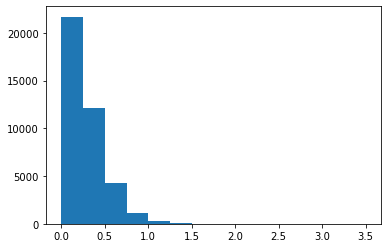

In [8]:
plt.hist(abs(test_df[col] - col_mean[col]), bins=14 , range=(0, 3.5))
plt.show()